In [1]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [41]:
!pip install -Uq fastai fastcore
!pip install -q pandas_read_xml ipython-autotime icevision[all] icedata
%load_ext autotime

ERROR: icevision 0.5.2 has requirement fastcore<1.3.3,>=1.3.0, but you'll have fastcore 1.3.19 which is incompatible.
ERROR: icevision 0.5.2 has requirement requests>=2.24.0<3, but you'll have requests 2.23.0 which is incompatible.
ERROR: icevision 0.5.2 has requirement requests>=2.24.0<3, but you'll have requests 2.23.0 which is incompatible.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.07 s (started: 2021-03-08 07:58:42 +00:00)


In [42]:
from google.colab.patches import *
import PIL
# from fastcore.parallel import *
from icevision.all import *
import icedata

time: 2.87 ms (started: 2021-03-08 07:58:48 +00:00)


# Datasets

## Neel's Dataset

In [4]:
from fastai.vision.all import *
import pandas as pd
import glob

time: 1.38 ms (started: 2021-03-08 07:43:29 +00:00)


In [13]:
%cd /content

/content
time: 1.16 ms (started: 2021-03-08 07:45:17 +00:00)


In [14]:
!rm '/content/pool+solar_panel.tar'
!cp '/content/drive/MyDrive/pool+solar_panel.tar' '/content/pool+solar_panel.tar'

rm: cannot remove '/content/pool+solar_panel.tar': No such file or directory
time: 12 s (started: 2021-03-08 07:45:18 +00:00)


In [ ]:
!rm -Rf pool+solar_panel/solar_panel_pool
!tar -xvf '/content/pool+solar_panel.tar'

In [16]:
imgs = glob.glob('/content/pool+solar_panel/*/img/*.*')
anns = glob.glob('/content/pool+solar_panel/*/ann/*.*')

def copy_file_to_location(file, location):
  shutil.copyfile(str(file), str(Path(location)/Path(file).name))

!mkdir -p /content/pool+solar_panel/img
!mkdir -p /content/pool+solar_panel/ann

for file in imgs:
  copy_file_to_location(file, '/content/pool+solar_panel/img')
for file in anns:
  copy_file_to_location(file, '/content/pool+solar_panel/ann')

time: 4.71 s (started: 2021-03-08 07:45:35 +00:00)


In [17]:
%cd /content/pool+solar_panel/

/content/pool+solar_panel
time: 2.82 ms (started: 2021-03-08 07:45:40 +00:00)


## Read kaggle data

In [21]:
!kaggle datasets download kbhartiya83/swimming-pool-and-car-detection

 98% 109M/111M [00:01<00:00, 72.7MB/s] 
100% 111M/111M [00:01<00:00, 85.3MB/s]
time: 2.43 s (started: 2021-03-08 07:46:19 +00:00)


In [22]:
!unzip -q \*.zip

time: 1.73 s (started: 2021-03-08 07:46:22 +00:00)


In [23]:
from pathlib import Path

TRAIN = Path('training_data/training_data')
TRAIN_IMG = TRAIN/'images'
TRAIN_LABELS = TRAIN/'labels'
TEST = Path('/test_data_images/test_data_images')
TEST_IMG = TEST/'images'

time: 2.26 ms (started: 2021-03-08 07:46:23 +00:00)


In [24]:
import glob
files = list(glob.glob(str(TRAIN_LABELS/'*.xml')))

time: 18.4 ms (started: 2021-03-08 07:46:23 +00:00)


In [25]:
import pandas_read_xml as pdx
from tqdm.notebook import tqdm

def _append_to_df(df, df1):
  return df.append(df1, ignore_index = True, sort = True)

def read_one_xml(xml):
  df = pdx.read_xml(xml).T
  df.index = [0]
  df = pdx.fully_flatten(df)
  return df

kaggle_df = read_one_xml(files[0])
for file in tqdm(files[1:]):
  df1 = read_one_xml(file)
  kaggle_df = _append_to_df(kaggle_df, df1)

  0%|          | 0/3747 [00:00<?, ?it/s]

time: 2min 36s (started: 2021-03-08 07:46:23 +00:00)


In [26]:
kaggle_df.head(1)

filename object|bndbox|xmax  ... size|width source|annotation
0  000003446.jpg             184.52  ...        224    ArcGIS Pro 2.1

[1 rows x 10 columns]

time: 27.2 ms (started: 2021-03-08 07:49:00 +00:00)


### Get bbox

In [27]:
def listify_df(df, cols): 
  for col in cols: df[col] = df[col].apply(lambda x: [x])
  return df

kaggle_df = listify_df(kaggle_df, cols = ['object|bndbox|xmin', 'object|bndbox|ymin', 'object|bndbox|xmax', 'object|bndbox|ymax'])
kaggle_df.head()

filename object|bndbox|xmax  ... size|width source|annotation
0  000003446.jpg           [184.52]  ...        224    ArcGIS Pro 2.1
1  000003446.jpg           [209.78]  ...        224    ArcGIS Pro 2.1
2  000002885.jpg            [99.43]  ...        224    ArcGIS Pro 2.1
3  000002483.jpg            [21.04]  ...        224    ArcGIS Pro 2.1
4  000002483.jpg            [39.27]  ...        224    ArcGIS Pro 2.1

[5 rows x 10 columns]

time: 46.8 ms (started: 2021-03-08 07:49:00 +00:00)


In [28]:
kaggle_df['bbox'] = kaggle_df['object|bndbox|xmin'] + \
                    kaggle_df['object|bndbox|ymin'] + \
                    kaggle_df['object|bndbox|xmax'] + \
                    kaggle_df['object|bndbox|ymax']
kaggle_df.head()

filename  ...                             bbox
0  000003446.jpg  ...   [140.07, 51.00, 184.52, 95.44]
1  000003446.jpg  ...  [165.34, 99.01, 209.78, 143.45]
2  000002885.jpg  ...   [88.32, 173.64, 99.43, 184.75]
3  000002483.jpg  ...       [0.00, 0.00, 21.04, 16.04]
4  000002483.jpg  ...     [0.00, 82.64, 39.27, 127.08]

[5 rows x 11 columns]

time: 144 ms (started: 2021-03-08 07:49:00 +00:00)


In [29]:
kaggle_df['class'] = kaggle_df['object|name']
# kaggle_df.head()

time: 1.68 ms (started: 2021-03-08 07:49:00 +00:00)


In [30]:
kaggle_df = kaggle_df.drop(['object|bndbox|xmin', 'object|bndbox|ymin', 'object|bndbox|xmax', 'object|bndbox|ymax'], axis = 1)
kaggle_df = kaggle_df.drop(['object|name', 'size|depth','size|height', 'size|width', 'source|annotation'], axis = 1)
kaggle_df.head()

filename                             bbox class
0  000003446.jpg   [140.07, 51.00, 184.52, 95.44]     2
1  000003446.jpg  [165.34, 99.01, 209.78, 143.45]     2
2  000002885.jpg   [88.32, 173.64, 99.43, 184.75]     1
3  000002483.jpg       [0.00, 0.00, 21.04, 16.04]     2
4  000002483.jpg     [0.00, 82.64, 39.27, 127.08]     2

time: 25.8 ms (started: 2021-03-08 07:49:01 +00:00)


### Copy imgs over

In [31]:
import shutil, glob
kaggle_files = glob.glob(str(TRAIN_IMG/'*.*g'))
for file in tqdm(kaggle_files):
  dest = str(Path('img')/Path(file).name)
  shutil.copyfile(file, dest)

  0%|          | 0/3748 [00:00<?, ?it/s]

time: 449 ms (started: 2021-03-08 07:49:01 +00:00)


### Filter out unnecessary information

In [32]:
# keep all class 2 imgs (pools)
kaggle_df['class'] = kaggle_df['class'].astype(int)
kaggle_df = kaggle_df[kaggle_df['class']==2]

time: 9.56 ms (started: 2021-03-08 07:49:01 +00:00)


In [33]:
# kaggle_df.head()

time: 627 µs (started: 2021-03-08 07:49:01 +00:00)


# Convert to Pandas

In [114]:
json_files = glob.glob('ann/*.json')
json_files[0:3]

[]

time: 8.08 ms (started: 2021-03-08 09:43:02 +00:00)


In [115]:
df = pd.DataFrame(columns = ['filename', 'bbox', 'class'])
for json_file_name in json_files:

    # print(Path(Path(json_file_name).stem).suffix[1:])

    img = Path(Path(json_file_name).stem).stem + '.' + Path(Path(json_file_name).stem).suffix[1:]
    # print(img)

    with open(json_file_name) as json_file:
      data = json.load(json_file)
      
      for o in data['objects']:
        label = o['classTitle']
        p1, p2 = o['points']['exterior']
        xmin = min(p1[0], p2[0])
        ymin = min(p1[1], p2[1])
        xmax = max(p1[0], p2[0])
        ymax = max(p1[1], p2[1])
      
      if len(data['objects']) == 0:
        pass
        # df2 = pd.DataFrame({'filename': img, 'bbox': None, 'class': None}, index = [0])
        # df = df.append(df2, ignore_index = True, sort = True)

      else:
        df2 = pd.DataFrame({'filename': img, 'bbox': [[xmin, ymin, xmax, ymax]], 'class': label})
        df = df.append(df2, ignore_index = True, sort = True)
          
df.head()

Empty DataFrame
Columns: [filename, bbox, class]
Index: []

time: 45 ms (started: 2021-03-08 09:43:04 +00:00)


In [116]:
df.shape

(0, 3)

time: 3.73 ms (started: 2021-03-08 09:43:04 +00:00)


## Remove unwanted data

In [117]:
df.shape

(0, 3)

time: 4.34 ms (started: 2021-03-08 09:43:04 +00:00)


In [118]:
def remove_solar_labels(row):
  if row['class'] == None: return row
  if 'pool' in row['class']:
    row['class'] = None
    row['bbox'] = None
  return row

df = df[df['class'].str.contains('pool')]
df.shape

(0, 3)

time: 9.41 ms (started: 2021-03-08 09:43:04 +00:00)


# Append Kaggle data

In [119]:
# kaggle_df.head()

time: 924 µs (started: 2021-03-08 09:43:04 +00:00)


In [120]:
kaggle_df['class'] = kaggle_df['class'].apply(lambda number: 'pool_rectangle')
kaggle_df['class'].value_counts()

pool_rectangle    3150
Name: class, dtype: int64

time: 9.2 ms (started: 2021-03-08 09:43:04 +00:00)


In [121]:
kaggle_df.shape, df.shape

((3150, 3), (0, 3))

time: 4.11 ms (started: 2021-03-08 09:43:04 +00:00)


In [122]:
# kaggle_df.head()

time: 543 µs (started: 2021-03-08 09:43:04 +00:00)


In [123]:
df = df.append(kaggle_df, ignore_index = True, sort = True)
# df.head()

time: 5.97 ms (started: 2021-03-08 09:43:04 +00:00)


In [124]:
df.shape

(3150, 3)

time: 2.25 ms (started: 2021-03-08 09:43:04 +00:00)


In [125]:
# PIL.Image.open(os.path.join('img', df.iloc[-500]['filename']))

time: 7.61 ms (started: 2021-03-08 09:43:04 +00:00)


In [126]:
# PIL.Image.open(os.path.join('img', df.iloc[-500]['filename'])).size

time: 632 µs (started: 2021-03-08 09:43:04 +00:00)


# Rearrange bbox

In [127]:
def rearrange_bbox(bbox):
  '''from [xmin, ymin, xmax, ymax] to [xmin, ymin, width, height]'''
  if bbox == None: return None
  xmin = float(bbox[0])
  ymin = float(bbox[1])
  width = float(bbox[2]) - xmin
  height = float(bbox[3]) - ymin
  return [xmin, ymin, width, height]

df['bbox'] = df['bbox'].apply(lambda bbox: rearrange_bbox(bbox))
df.head(1)

bbox           class       filename
0  [140.07, 51.0, 44.45000000000002, 44.44]  pool_rectangle  000003446.jpg

time: 33.6 ms (started: 2021-03-08 09:43:04 +00:00)


# Create class number

In [128]:
df['class'].value_counts()

pool_rectangle    3150
Name: class, dtype: int64

time: 5.29 ms (started: 2021-03-08 09:43:04 +00:00)


In [129]:
df['class'].isna().sum()

0

time: 3.59 ms (started: 2021-03-08 09:43:04 +00:00)


In [130]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['class'])
df.head(1)

bbox  ... label
0  [140.07, 51.0, 44.45000000000002, 44.44]  ...     0

[1 rows x 4 columns]

time: 21.3 ms (started: 2021-03-08 09:43:04 +00:00)


In [131]:
# def add_label(row):
#   if row['class'] == None: return row
#   if 'solar' in row['class']:
#     row['label'] = 1
#   return row

# df['label'] = 0
# df = df.apply(lambda row: add_label(row), axis = 1)
# df.head()

time: 1.83 ms (started: 2021-03-08 09:43:04 +00:00)


In [132]:
# source = Path("/home/lgvaz/data/wheat")
# df = pd.read_csv(source / "train.csv")
# df.head()

time: 681 µs (started: 2021-03-08 09:43:04 +00:00)


# Icevision


## Modify icevision/utils/imageio.py

In [133]:
%%writefile /usr/local/lib/python3.7/dist-packages/icevision/utils/imageio.py

__all__ = [
    "open_img",
    "get_image_size",
    "show_img",
    "plot_grid",
    "plot_grid_preds_actuals",
]

from icevision.imports import *
import PIL, imagesize


def open_img(fn, gray=False):
    color = "L" if gray else "RGB" # modify to RGBA
    return np.array(PIL.Image.open(str(fn)).convert('RGBA'))


def get_image_size(filepath: Union[str, Path]) -> Tuple[int, int]:
    """
    Returns image (width, height)
    """
    return imagesize.get(filepath)


def show_img(img, ax=None, show: bool = False, **kwargs):
    img = img.squeeze().copy()
    cmap = "gray" if len(img.shape) == 2 else None

    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    ax.imshow(img, cmap=cmap)
    ax.set_axis_off()

    if show:
        plt.show()

    return ax


def plot_grid(fs: List[callable], ncols=1, figsize=None, show=False, **kwargs):
    nrows = math.ceil(len(fs) / ncols)
    figsize = figsize or (12 * ncols, 12 * nrows)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, **kwargs)
    axs = np.asarray(axs)
    for f, ax in zip(fs, axs.flatten()):
        f(ax=ax)

    plt.tight_layout()
    if show:
        plt.show()


def plot_grid_preds_actuals(
    actuals, predictions, figsize=None, show=False, annotations=None, **kwargs
):
    fig, axs = plt.subplots(
        nrows=len(actuals),
        ncols=2,
        figsize=figsize or (6, 6 * len(actuals) / 2 / 0.75),
        **kwargs,
    )
    i = 0
    for im, ax in zip(zip(actuals, predictions), axs.reshape(-1, 2)):
        ax[0].imshow(im[0], cmap=None)
        ax[0].set_title("Ground truth")
        ax[1].imshow(im[1], cmap=None)
        ax[1].set_title("Prediction")

        if annotations is None:
            ax[0].set_axis_off()
            ax[1].set_axis_off()
        else:
            ax[0].get_xaxis().set_ticks([])
            ax[0].set_frame_on(False)
            ax[0].get_yaxis().set_visible(False)
            ax[0].set_xlabel(annotations[i][0], ma="left")

            ax[1].get_xaxis().set_ticks([])
            ax[1].set_frame_on(False)
            ax[1].get_yaxis().set_visible(False)
            ax[1].set_xlabel(annotations[i][1], ma="left")

            i += 1

    plt.tight_layout()
    if show:
        plt.show()
    return axs


Overwriting /usr/local/lib/python3.7/dist-packages/icevision/utils/imageio.py
time: 4.71 ms (started: 2021-03-08 09:43:04 +00:00)


## Modify load

In [134]:
from fastcore.foundation import patch
from icevision import parsers, FilepathRecordMixin
from torchvision import io

@patch
def _load(self:FilepathRecordMixin):
    torch_img = io.read_image(str(self.filepath))
    c, self.height, self.width = torch_img.shape
    if c == 1: torch_img = torch_img.float().mean(dim=0).repeat((3,1,1)).byte()
    # CHW to HWC
    self.img = torch_img.permute(1,2,0).numpy()
    # TODO, HACK: is it correct to overwrite height and width here?
    return

time: 6.26 ms (started: 2021-03-08 09:43:04 +00:00)


## Create the Parser

In [135]:
%cd /content/

/content
time: 2.37 ms (started: 2021-03-08 09:43:04 +00:00)


In [136]:
class DatasetParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source):
        self.df = df
        self.source = Path(source)

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> Hashable:
        return Path(o.filename).stem

    def filepath(self, o) -> Union[str, Path]:
        return self.source/o.filename

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[Hashable]:
        return [int(o.label)]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox, sep=","))]
        # return [BBox.from_xywh(*np.array(df.bbox[1:-1], dtype=np.uint8))]

time: 28.5 ms (started: 2021-03-08 09:43:04 +00:00)


In [137]:
df['bbox'] = df['bbox'].apply(lambda l: None if l == None else [str(i) for i in l])
df['bbox'] = df['bbox'].apply(lambda l: None if l == None else ','.join(l)) # hacky solution 
df.head()

bbox           class       filename  label
0   140.07,51.0,44.45000000000002,44.44  pool_rectangle  000003446.jpg      0
1  165.34,99.01,44.44,44.43999999999998  pool_rectangle  000003446.jpg      0
2                   0.0,0.0,21.04,16.04  pool_rectangle  000002483.jpg      0
3                 0.0,82.64,39.27,44.44  pool_rectangle  000002483.jpg      0
4                116.43,0.0,44.44,31.68  pool_rectangle  000000910.jpg      0

time: 26.2 ms (started: 2021-03-08 09:43:04 +00:00)


In [138]:
parser = DatasetParser(df, "/content/pool+solar_panel/img")
train_records, valid_records = parser.parse()

  0%|          | 0/3150 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


time: 9.16 s (started: 2021-03-08 09:43:04 +00:00)


## Visualise

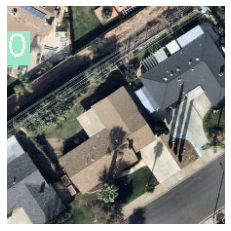

time: 106 ms (started: 2021-03-08 09:43:13 +00:00)


In [139]:
show_record(train_records[0], display_label=True)

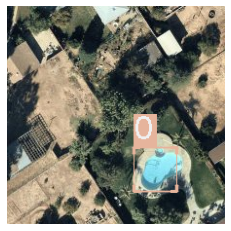

time: 101 ms (started: 2021-03-08 09:43:13 +00:00)


In [140]:
show_record(train_records[1], display_label=True)

In [141]:
len(train_records)

1594

time: 2.51 ms (started: 2021-03-08 09:43:13 +00:00)


## Transforms



### custom tfms

In [152]:
import tifffile

def _change_file_extension(file, extension):
  new_file_name = Path(file).stem + extension
  new_file_name = str(Path(file).parents[0]/new_file_name)
  return new_file_name

def _run_relative_luminance(img, show = False, verbose = False):
  # BGR
  # print(img.shape)
  B = img[:, :, 0]
  G = img[:, :, 1]
  R = img[:, :, 2]
  L = 0.2126*R+0.7152*G+0.0722*B # from https://en.wikipedia.org/wiki/Relative_luminance

  # img = np.expand_dims(img, axis = 2) 
  L = L[:, :, np.newaxis] # add dimension
  if verbose: print(L.shape); print(img.shape)
  img = np.concatenate((img, L), axis = 2) # concat relative luminance to img
  # img = np.append(img, L, axis = 1)
  if verbose: print(img.shape)

  if show:
    # cv2_imshow(B)
    # cv2_imshow(G)
    # cv2_imshow(R)
    # cv2_imshow(L)
    cv2_imshow(img)
  return img

def _save_arr_as_image(arr, output, show = False):
  if Path(output).exists(): os.remove(output)
  # cv2.imwrite(str(output), arr)
  # tifffile.imsave(output, arr)
  im_pil = PIL.Image.fromarray((arr * 255).astype(np.uint8))
  im_pil.save(output)
  if show:
    img = cv2.imread(str(output))
    # img = tifffile.imread(output)
    cv2_imshow(img)

def add_relative_luminance_band(df, extension = '.png', verbose = False, show = False, limit = 10):

  for file in tqdm(df['filename'].unique()[:limit]):
    img = cv2.imread(os.path.join('img',file))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # cv2_imshow(img)
    arr = _run_relative_luminance(img, verbose = verbose, show = show)
    if verbose: print(arr.shape)

    new_file_name = Path('img')/_change_file_extension(file, extension = extension)
    if verbose: print(new_file_name)

    # arr_new = arr.reshape((4, arr.shape[0], arr.shape[1]))
    if verbose: print(arr.shape)

    _save_arr_as_image(arr, new_file_name, show = show)

# add_relative_luminance_band(df, extension = '.tiff', verbose = False, show = True, limit = 10)

time: 53.1 ms (started: 2021-03-08 09:55:43 +00:00)


In [154]:
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F

class relative_luminance(ImageOnlyTransform):
    
    """
    Implemntation of "Single Image Haze Removal using Dark Channel Prior＂
    from: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36809
    http://mmlab.ie.cuhk.edu.hk/archive/2011/Haze.pdf 
    https://github.com/He-Zhang/image_dehaze/blob/master/dehaze.py
    """

    def __init__(self, always_apply=False, p=0.5):
        super(relative_luminance, self).__init__(always_apply, p)

    def apply(self, img, **params):
        return _run_relative_luminance(img, show = False, verbose = False)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        return {}

    def get_transform_init_args_names(self):
        return ()

    @property
    def targets_as_params(self):
        return ["image"]

time: 10.1 ms (started: 2021-03-08 09:56:02 +00:00)


### Albumentations tfms

In [155]:
presize = 512
size = 384

time: 1.02 ms (started: 2021-03-08 09:56:04 +00:00)


In [156]:
valid_tfms = tfms.A.Adapter([
                             *tfms.A.resize_and_pad(size),\
                             tfms.A.VerticalFlip(),\
                             tfms.A.HorizontalFlip(),\
                             tfms.A.Normalize()
                             ])

train_tfms = tfms.A.Adapter([
                             *tfms.A.aug_tfms(size=size, presize=presize),\
                             tfms.A.RandomResizedCrop(size, size, p = 1),\
                             tfms.A.VerticalFlip(),\
                             tfms.A.HorizontalFlip(),\
                            #  image_dehaze(),\
                             tfms.A.MedianBlur(blur_limit = 3),\
                             tfms.A.GaussNoise(),\
                            #  tfms.A.ChannelDropout(),\
                            #  tfms.A.ChannelShuffle(),\
                             tfms.A.Transpose(),\
                             tfms.A.ShiftScaleRotate(),\
                             tfms.A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),\
                             tfms.A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),\
                            #  tfms.A.Cutout(),\
                            #  tfms.A.Downscale(),\
                             relative_luminance(),\
                             tfms.A.Normalize()
                            ])

time: 14.4 ms (started: 2021-03-08 09:56:07 +00:00)


## Dataset

The `Dataset` class combines the records and transforms.

To create a `Dataset`, we just need need to pass the parsed records from the previous step along with the transforms.


In [157]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

time: 1.06 ms (started: 2021-03-08 09:56:09 +00:00)


### Displaying the same image with different transforms

In [158]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3)

ValueError: ignored

time: 200 ms (started: 2021-03-08 09:56:10 +00:00)


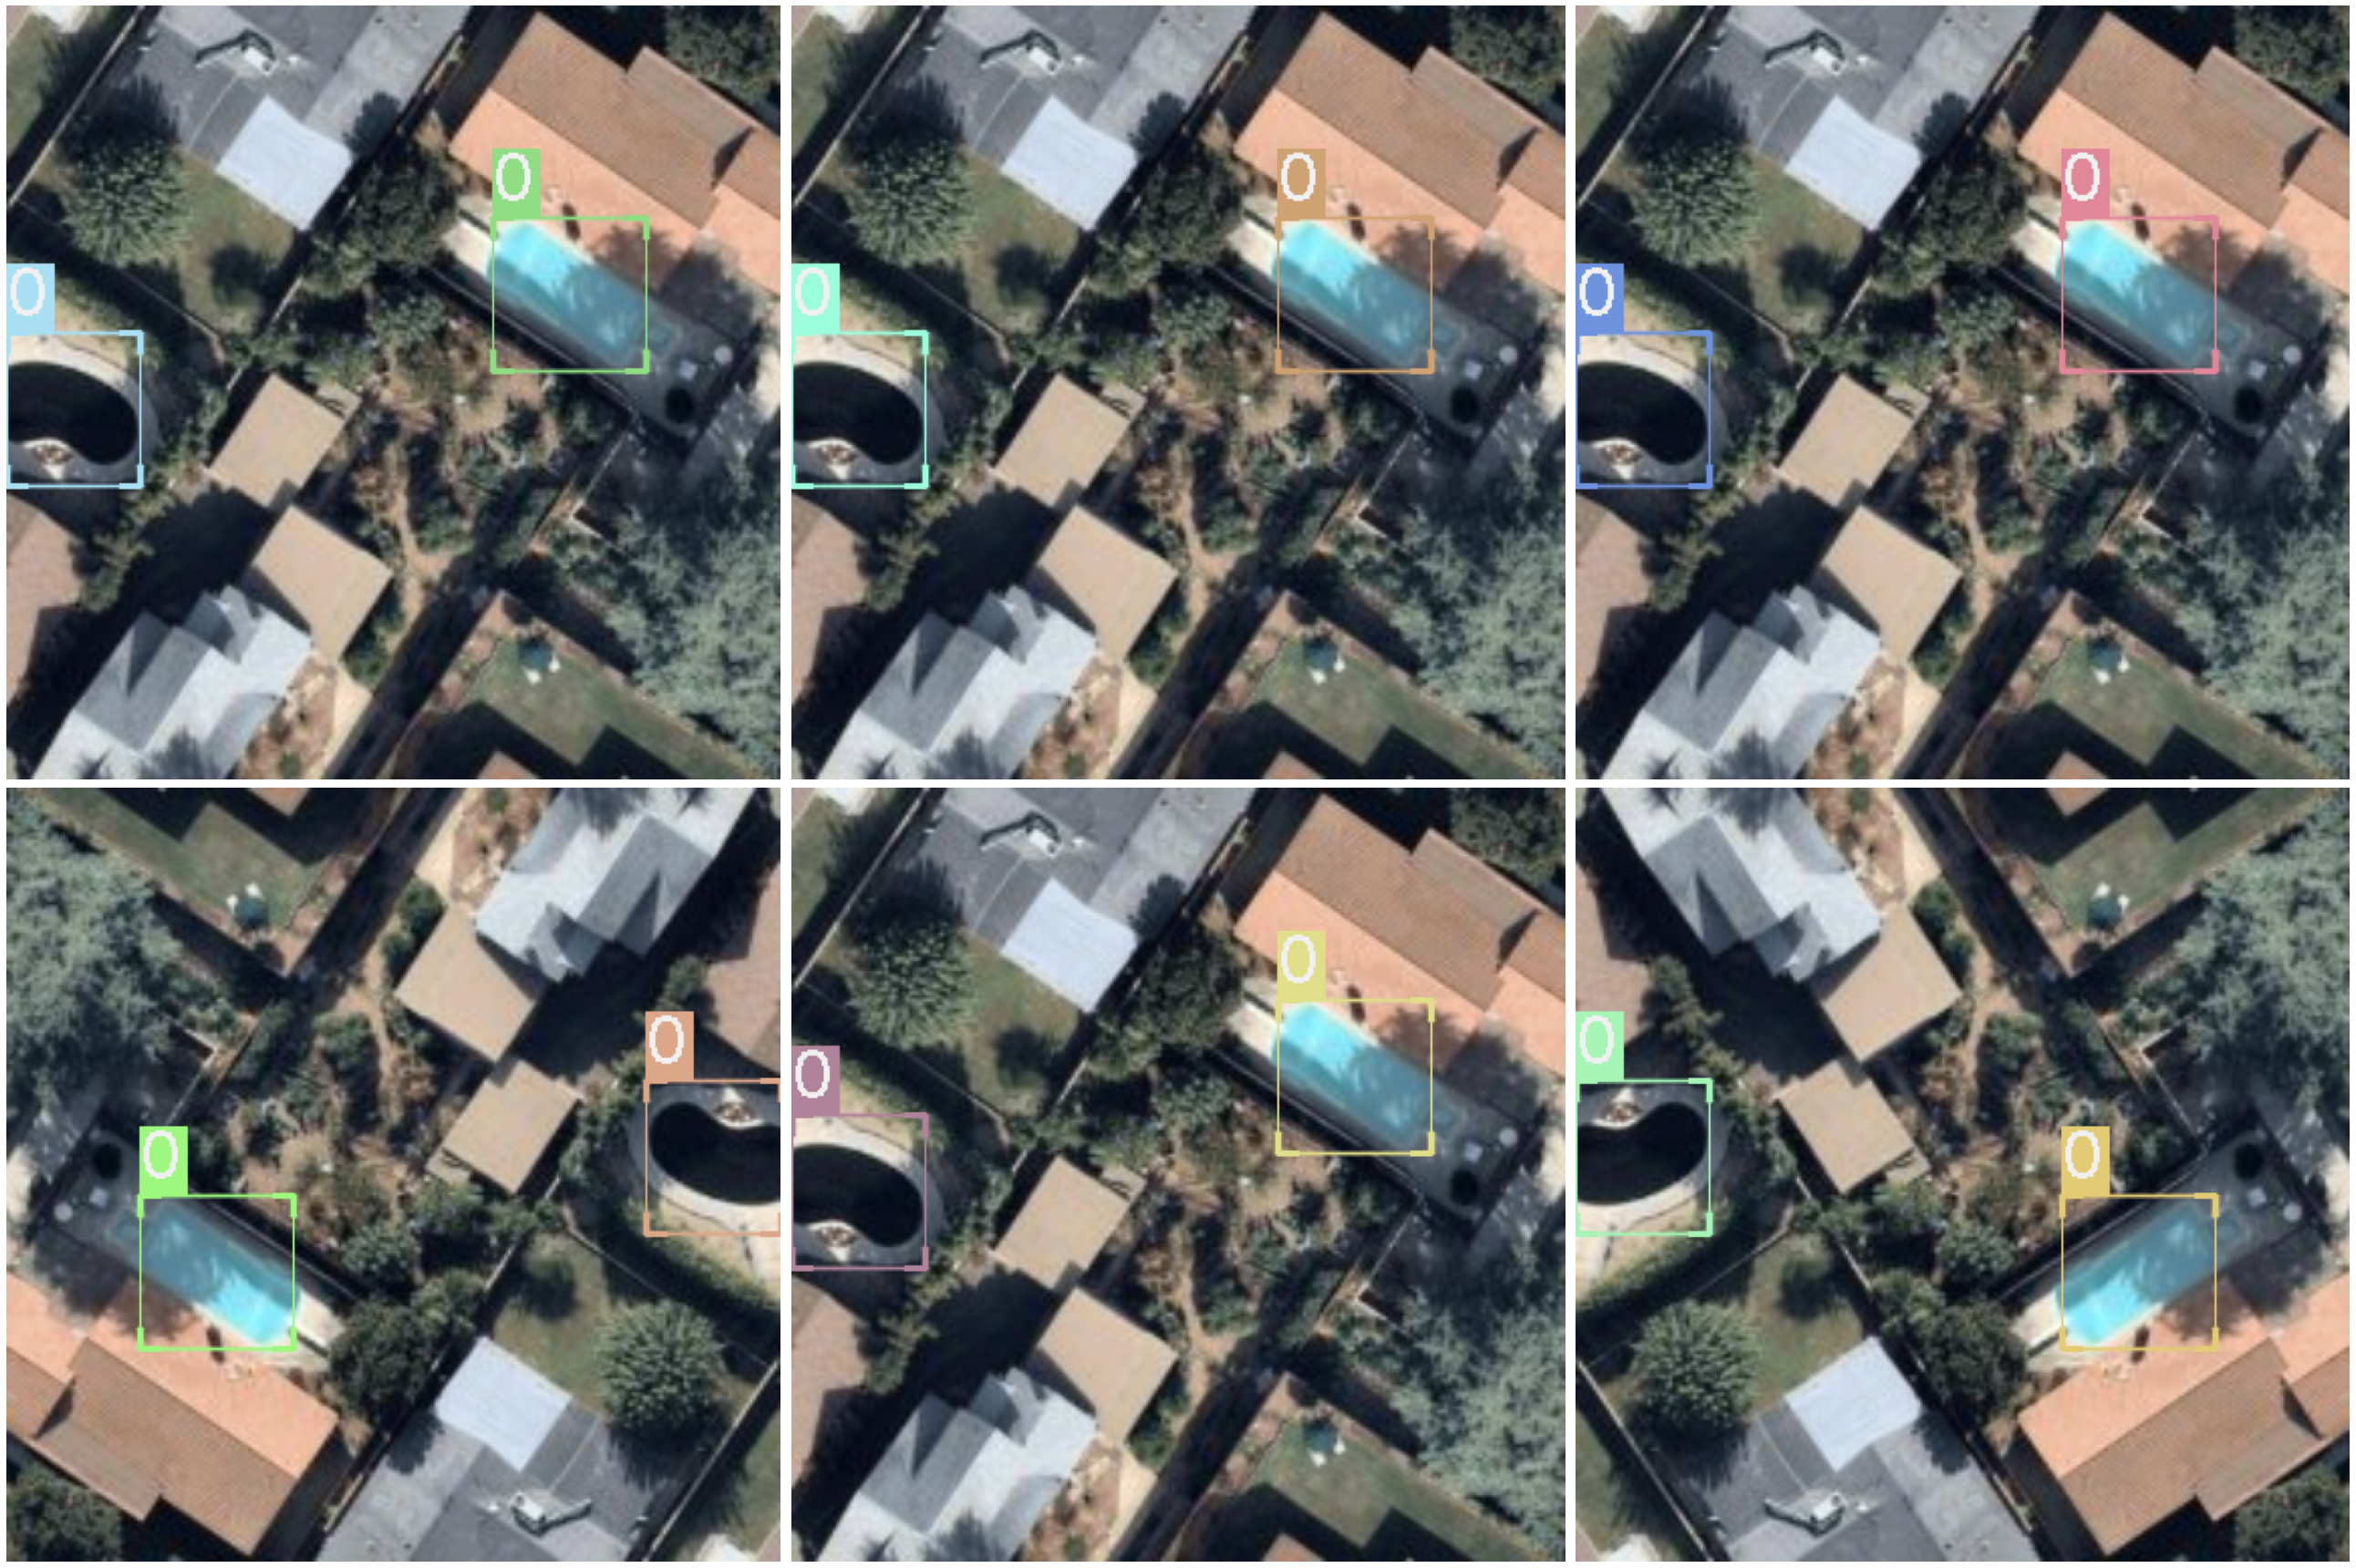

time: 3.91 s (started: 2021-03-08 09:43:18 +00:00)


In [146]:
samples = [valid_ds[3] for _ in range(6)]
show_samples(samples, ncols=3)

## Training 


In [147]:
def free_mem():
  import gc;gc.collect()
  torch.cuda.empty_cache()

model = faster_rcnn.model(num_classes=2) # changed

time: 1.02 s (started: 2021-03-08 09:43:22 +00:00)


In [148]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

time: 1.97 ms (started: 2021-03-08 09:43:23 +00:00)


In [149]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

time: 874 µs (started: 2021-03-08 09:43:23 +00:00)


## Fit one cycle

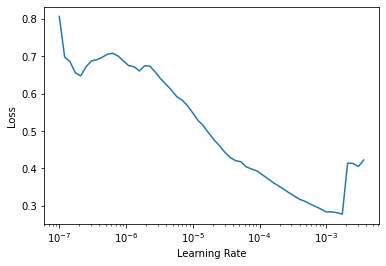

time: 8min 53s (started: 2021-03-08 09:43:23 +00:00)


In [150]:
free_mem()
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
lr, _ = learn.lr_find()
learn.fit_one_cycle(5, lr*10)

In [151]:
learn.fit_one_cycle(5, lr)

KeyboardInterrupt: ignored

time: 2min 23s (started: 2021-03-08 09:52:16 +00:00)


In [ ]:
lr, _ = learn.lr_find()
learn.fit_one_cycle(5, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fit_one_cycle(5, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fit_one_cycle(10, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fit_one_cycle(10, lr)

In [ ]:
faster_rcnn.show_results(model, valid_ds)

## Fine tune

In [ ]:
free_mem()
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
faster_rcnn.show_results(model, valid_ds)

## Labelsmoothing

In [ ]:
learn.loss_func = LabelSmoothingCrossEntropy()

In [ ]:
free_mem()
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
learn.unfreeze()
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
learn.unfreeze()
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
faster_rcnn.show_results(model, valid_ds)

## EfficientDet

In [ ]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [ ]:
model = efficientdet.model(model_name='tf_efficientdet_lite0', num_classes=2, img_size=size)

In [ ]:
metrics = [COCOMetric()]

In [ ]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

### Fastai Training

In [ ]:
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
lr, _ = learn.lr_find()
learn.fine_tune(10, lr)

In [ ]:
efficientdet.show_results(model, valid_ds)